In [1]:
import pandas as pd
import numpy as np
from scipy import stats as stats
import matplotlib.pyplot as plt
import seaborn as sb
import KeyFunctions as me
import tensorflow as tf
RandState = 117

from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, MaxPooling2D, LSTM
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

n = 20

In [2]:
from sklearn.model_selection import train_test_split

#Import Full R6g Dataset
df, labels = me.ConstructCombinedDataset()

[train, test] = train_test_split(df, random_state = RandState, shuffle = True, train_size = 0.8)

y_tn = train.index
y_tt = test.index
X_tt = test.to_numpy()
X_tn = train.to_numpy()

#Augment Data to 4000 Spectra
X_tnAu, y_tnAu = me.AugmentData(X_tn, y_tn, 4000, df.columns.to_numpy(), False)

In [3]:
#Set Training Parameters
verbose = 1
epochsvec = [5, 20, 50]
batch_sizevec = [10, 50, 100]
epochs = epochsvec[1]
batch_size = batch_sizevec[1]

In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

#Scale X-Data with Training Xs
scaler = StandardScaler()
scaler.fit(X_tnAu)
X_tnS = scaler.transform(X_tnAu)
X_ttS = scaler.transform(X_tt)

#Encode y-Data with Training ys
encoder = LabelEncoder()
encoder.fit(y_tnAu)
y_tn_e = encoder.transform(y_tnAu)
y_tn_p = np_utils.to_categorical(y_tn_e, num_classes = len(labels))
y_tt_e = encoder.transform(y_tt)
y_tt_p = np_utils.to_categorical(y_tt_e, num_classes = len(labels))


#Reshape All Data to a 3D Tensor of Shape [Number of Spectra, Number of Timesteps(1), Number of Wavelengths]
X_tn_p = X_tnS.reshape(X_tnS.shape[0], X_tnS.shape[1], 1)
X_tt_p = X_ttS.reshape(X_ttS.shape[0], X_ttS.shape[1], 1)

y_tnT = tf.convert_to_tensor(y_tn_p)
y_ttT = tf.convert_to_tensor(y_tt_p)
X_tnT = tf.convert_to_tensor(X_tn_p)
X_ttT = tf.convert_to_tensor(X_tt_p)

display(X_tnT.shape)
display(y_tnT.shape)
display(X_ttT.shape)
display(y_ttT.shape)

ytruth = tf.argmax(input = y_ttT, axis = 1).numpy()
ytruth = encoder.inverse_transform(ytruth)

TensorShape([4000, 472, 1])

TensorShape([4000, 8])

TensorShape([23, 472, 1])

TensorShape([23, 8])

In [5]:
#Multi-class Classification with Keras
 
n_timesteps, n_features, n_outputs = X_tn_p.shape[1], X_tn_p.shape[2], y_tn_p.shape[1]

#Define Sequential Model - 1 Convolution Layer, 1 Dropout Layer, 1 Flatten Layer, 2 Dense Layers
model = Sequential()
model.add(LSTM(100 ,input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Implement EarlyStopping
stopper = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",patience = 4,verbose = 0, restore_best_weights = True)

#Fit Model
history_sc = model.fit(X_tnT, y_tnT, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_split = 0.2, callbacks = stopper)

#Evaluate Model
_, SCaccuracy = model.evaluate(X_ttT, y_ttT, batch_size=batch_size, verbose=verbose)
display(SCaccuracy)

Epoch 1/20
64/64 [==============================] - 14s 189ms/step - loss: 1.8644 - accuracy: 0.2659 - val_loss: 1.7969 - val_accuracy: 0.3175
Epoch 2/20
64/64 [==============================] - 12s 192ms/step - loss: 1.8250 - accuracy: 0.2822 - val_loss: 1.7466 - val_accuracy: 0.3175
Epoch 3/20
64/64 [==============================] - 10s 151ms/step - loss: 1.8420 - accuracy: 0.2672 - val_loss: 1.7672 - val_accuracy: 0.2912
Epoch 4/20
64/64 [==============================] - 10s 154ms/step - loss: 1.7614 - accuracy: 0.2912 - val_loss: 1.6922 - val_accuracy: 0.3175
Epoch 5/20
64/64 [==============================] - 9s 147ms/step - loss: 1.7304 - accuracy: 0.3038 - val_loss: 1.7172 - val_accuracy: 0.3150
Epoch 6/20
64/64 [==============================] - 10s 152ms/step - loss: 1.7307 - accuracy: 0.3006 - val_loss: 1.6930 - val_accuracy: 0.3325
Epoch 7/20
64/64 [==============================] - 9s 149ms/step - loss: 1.7256 - accuracy: 0.3041 - val_loss: 1.6907 - val_accuracy: 0.3375
E

0.47826087474823

In [6]:
#Make Prediction
SCypred = model.predict(X_ttT)
SCypred = tf.argmax(input = SCypred, axis = 1).numpy()
SCypred = encoder.inverse_transform(SCypred)


In [7]:
#Extract Convolution Feature Maps
convlayer = tf.keras.Model(inputs=model.inputs, outputs=model.layers[0].output)

spectra = X_ttT[n, :, 0]
specvec = list()
specvec.append(spectra)
spectra = tf.reshape(spectra, (1, len(spectra), 1))

SCfeature_maps = convlayer.predict(spectra)
display(SCfeature_maps)

array([[-0.06934094, -0.04568164, -0.02448903,  0.02914456,  0.08187588,
        -0.03522462,  0.07279321,  0.0018662 , -0.08324973,  0.03393687,
        -0.02345295,  0.02857039,  0.04293058,  0.03027898,  0.04078862,
        -0.00317495, -0.10949314,  0.07712725,  0.02098852,  0.06896655,
        -0.05457757, -0.00042751,  0.05581718,  0.03542165, -0.0193221 ,
        -0.06314343, -0.04634826, -0.03754557, -0.07556656,  0.05857   ,
        -0.03473919, -0.07424548,  0.00337759, -0.07780289,  0.07389589,
         0.07393703, -0.05992082, -0.0133984 , -0.08163378, -0.07730187,
        -0.1322496 ,  0.07921546, -0.03311779, -0.0434295 ,  0.0579382 ,
        -0.05420648, -0.07511345,  0.05538918, -0.0570353 ,  0.0911311 ,
        -0.04414877, -0.06644144, -0.04874471, -0.04764149,  0.07737766,
         0.02134402,  0.05941137, -0.03313393,  0.03240867,  0.06677222,
        -0.04423384, -0.03262516,  0.01929553, -0.08753755, -0.10068137,
        -0.06642341, -0.00577987, -0.01344777,  0.0

In [8]:
#Apply Fourier Transform to Training and Testing Data
X_tnf = np.apply_along_axis(np.fft.fft, axis=1, arr=X_tnAu)
X_ttf = np.apply_along_axis(np.fft.fft, axis=1, arr=X_tt)

#Combine Real and Imaginary Part of FT in form [real, imaginary]
X_tnf = np.append(X_tnf.real, X_tnf.imag, axis = 1)
X_ttf = np.append(X_ttf.real, X_ttf.imag, axis = 1)
X_tnf= X_tnf.astype('float32')
X_ttf= X_ttf.astype('float32')

#Scale X-Data with Training Xs
scaler = StandardScaler()
scaler.fit(X_tnf)
X_tnf = scaler.transform(X_tnf)
X_ttf = scaler.transform(X_ttf)

#Encode y-Data with Training ys
encoder = LabelEncoder()
encoder.fit(y_tnAu)
y_tn_e = encoder.transform(y_tnAu)
y_tn_p = np_utils.to_categorical(y_tn_e, num_classes = len(labels))
y_tt_e = encoder.transform(y_tt)
y_tt_p = np_utils.to_categorical(y_tt_e, num_classes = len(labels))

#Reshape All Data to a 3D Tensor of Shape [Number of Spectra, Number of Timesteps(1), Number of Wavelengths]
X_tn_p = X_tnf.reshape(X_tnf.shape[0], X_tnf.shape[1], 1)
X_tt_p = X_ttf.reshape(X_ttf.shape[0], X_ttf.shape[1], 1)

y_tnT = tf.convert_to_tensor(y_tn_p)
y_ttT = tf.convert_to_tensor(y_tt_p)
X_tnT = tf.convert_to_tensor(X_tn_p)
X_ttT = tf.convert_to_tensor(X_tt_p)


display(X_tnT.shape)
display(y_tnT.shape)
display(X_ttT.shape)
display(y_ttT.shape)

TensorShape([4000, 944, 1])

TensorShape([4000, 8])

TensorShape([23, 944, 1])

TensorShape([23, 8])

In [9]:
#Multi-class Classification with Keras
 
n_timesteps, n_features, n_outputs = X_tn_p.shape[1], X_tn_p.shape[2], y_tn_p.shape[1]

#Define Sequential Model - 1 Convolution Layer, 1 Dropout Layer, 1 Flatten Layer, 2 Dense Layers
model = Sequential()
model.add(LSTM(100 ,input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Implement EarlyStopping
stopper = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",patience = 2,verbose = 0, restore_best_weights = True)

#Fit Model
history_ft = model.fit(X_tnT, y_tnT, epochs=epochs, batch_size=batch_size, verbose=verbose,  validation_split=0.2, callbacks = stopper)

#Evaluate Model
_, FTaccuracy = model.evaluate(X_ttT, y_ttT, batch_size=batch_size, verbose=verbose)
display(FTaccuracy)

Epoch 1/20
64/64 [==============================] - 21s 303ms/step - loss: 1.8640 - accuracy: 0.2859 - val_loss: 1.6491 - val_accuracy: 0.4137
Epoch 2/20
64/64 [==============================] - 19s 292ms/step - loss: 1.4454 - accuracy: 0.4153 - val_loss: 1.2171 - val_accuracy: 0.4450
Epoch 3/20
64/64 [==============================] - 19s 293ms/step - loss: 1.1151 - accuracy: 0.5281 - val_loss: 0.9998 - val_accuracy: 0.5813
Epoch 4/20
64/64 [==============================] - 19s 291ms/step - loss: 1.0157 - accuracy: 0.5759 - val_loss: 0.9313 - val_accuracy: 0.6112
Epoch 5/20
64/64 [==============================] - 19s 297ms/step - loss: 0.9118 - accuracy: 0.5972 - val_loss: 0.8625 - val_accuracy: 0.6263
Epoch 6/20
64/64 [==============================] - 19s 297ms/step - loss: 0.8843 - accuracy: 0.6050 - val_loss: 0.8884 - val_accuracy: 0.5938
Epoch 7/20
1/1 [==============================] - 1s 939ms/step - loss: 0.8343 - accuracy: 0.5217


0.52173912525177

In [10]:
#Make Prediction
FTypred = model.predict(X_ttT)
FTypred = tf.argmax(input = FTypred, axis = 1).numpy()
FTypred = encoder.inverse_transform(FTypred)

In [11]:
convlayer = tf.keras.Model(inputs=model.inputs, outputs=model.layers[0].output)
convlayer.summary()

spectra = X_ttT[n, :, 0]
specvec.append(spectra)
spectra = tf.reshape(spectra, (1, len(spectra), 1))

FTfeature_maps = convlayer.predict(spectra)
display(FTfeature_maps)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1_input (InputLayer)    [(None, 944, 1)]          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               40800     
Total params: 40,800
Trainable params: 40,800
Non-trainable params: 0
_________________________________________________________________


array([[ 0.10944735,  0.01659597, -0.0954067 ,  0.07048382,  0.03905797,
        -0.05093683,  0.05544046, -0.00530042,  0.09328555, -0.10861853,
         0.00828061, -0.01113954, -0.06981295,  0.03200042,  0.13451782,
         0.08588584,  0.04496095,  0.09118361, -0.10217663,  0.12208646,
         0.06451358,  0.08480964, -0.01542988,  0.00108573,  0.01247848,
         0.08451456,  0.28435895,  0.00808161, -0.04458497, -0.05382335,
        -0.07374054, -0.03432702,  0.02149615, -0.01949558,  0.09943249,
         0.00162627, -0.03145202, -0.11393613,  0.03542631,  0.13731432,
        -0.0277319 ,  0.11614409,  0.10880762, -0.0312061 , -0.17306942,
         0.00462288,  0.15080002, -0.0364857 , -0.05017813, -0.0008733 ,
         0.11037017,  0.06930392, -0.08671992, -0.10978242, -0.02187668,
         0.06255905,  0.08397657, -0.12390617, -0.05252945,  0.13591902,
        -0.06414518, -0.12791035, -0.03709048,  0.12320895,  0.0082421 ,
         0.09783673,  0.07521028,  0.04129048, -0.0

In [12]:
#Apply Welsh-Hadamard Transform to Training and Testing Data
from sympy.discrete.transforms import fwht, ifwht
X_tnh = np.apply_along_axis(fwht, axis=1, arr=X_tnAu)
X_tth = np.apply_along_axis(fwht, axis=1, arr=X_tt)
X_tnh = X_tnh.astype('float32')
X_tth = X_tth.astype('float32')

#Scale X-Data with Training Xs
scaler = StandardScaler()
scaler.fit(X_tnh)
X_tnh = scaler.transform(X_tnh)
X_tth = scaler.transform(X_tth)

#Encode y-Data with Training ys
encoder = LabelEncoder()
encoder.fit(y_tnAu)
y_tn_e = encoder.transform(y_tnAu)
y_tn_p = np_utils.to_categorical(y_tn_e, num_classes = len(labels))
y_tt_e = encoder.transform(y_tt)
y_tt_p = np_utils.to_categorical(y_tt_e, num_classes = len(labels))

#Reshape All Data to a 3D Tensor of Shape [Number of Spectra, Number of Timesteps(1), Number of Wavelengths]
X_tn_p = X_tnh.reshape(X_tnh.shape[0], X_tnh.shape[1], 1)
X_tt_p = X_tth.reshape(X_tth.shape[0], X_tth.shape[1], 1)

y_tnT = tf.convert_to_tensor(y_tn_p)
y_ttT = tf.convert_to_tensor(y_tt_p)
X_tnT = tf.convert_to_tensor(X_tn_p)
X_ttT = tf.convert_to_tensor(X_tt_p)


display(X_tnT.shape)
display(y_tnT.shape)
display(X_ttT.shape)
display(y_ttT.shape)

TensorShape([4000, 512, 1])

TensorShape([4000, 8])

TensorShape([23, 512, 1])

TensorShape([23, 8])

In [13]:
#Multi-class Classification with Keras
 
n_timesteps, n_features, n_outputs = X_tn_p.shape[1], X_tn_p.shape[2], y_tn_p.shape[1]

#Define Sequential Model - 1 Convolution Layer, 1 Dropout Layer, 1 Flatten Layer, 2 Dense Layers
model = Sequential()
model.add(LSTM(100 ,input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Implement EarlyStopping
stopper = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", mode = 'min',\
                                           patience = 2, verbose = 1, restore_best_weights = True)

#Fit Model
history_ht = model.fit(X_tnT, y_tnT, epochs=epochs, batch_size=batch_size, verbose=verbose,  validation_split=0.2, callbacks = stopper)

#Evaluate Model
_, HTaccuracy = model.evaluate(X_ttT, y_ttT, batch_size=batch_size, verbose=verbose)
display(HTaccuracy)

Epoch 1/20
64/64 [==============================] - 13s 176ms/step - loss: 1.7108 - accuracy: 0.3372 - val_loss: 1.3846 - val_accuracy: 0.4462
Epoch 2/20
64/64 [==============================] - 11s 172ms/step - loss: 1.3017 - accuracy: 0.4462 - val_loss: 1.2346 - val_accuracy: 0.5875
Epoch 3/20
64/64 [==============================] - 11s 165ms/step - loss: 1.2467 - accuracy: 0.4669 - val_loss: 1.1535 - val_accuracy: 0.6050
Epoch 4/20
64/64 [==============================] - 11s 168ms/step - loss: 1.0981 - accuracy: 0.5431 - val_loss: 0.9886 - val_accuracy: 0.6112
Epoch 5/20
64/64 [==============================] - 11s 169ms/step - loss: 1.0538 - accuracy: 0.5597 - val_loss: 0.9869 - val_accuracy: 0.5450
Epoch 6/20
64/64 [==============================] - 11s 165ms/step - loss: 0.9740 - accuracy: 0.5831 - val_loss: 0.9293 - val_accuracy: 0.5575
Epoch 7/20
64/64 [==============================] - 11s 169ms/step - loss: 0.9185 - accuracy: 0.6034 - val_loss: 0.9541 - val_accuracy: 0.5400

0.8260869383811951

In [14]:
#Make Prediction
HTypred = model.predict(X_ttT)
HTypred = tf.argmax(input = HTypred, axis = 1).numpy()
HTypred = encoder.inverse_transform(HTypred)

In [15]:
convlayer = tf.keras.Model(inputs=model.inputs, outputs=model.layers[0].output)
convlayer.summary()

spectra = X_ttT[n, :, 0]
specvec.append(spectra)
spectra = tf.reshape(spectra, (1, len(spectra), 1))

HTfeature_maps = convlayer.predict(spectra)
display(HTfeature_maps)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2_input (InputLayer)    [(None, 512, 1)]          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               40800     
Total params: 40,800
Trainable params: 40,800
Non-trainable params: 0
_________________________________________________________________


array([[-0.07325096,  0.01034697,  0.05381091,  0.01525669,  0.0013684 ,
         0.0606374 , -0.00742786, -0.15211248, -0.03783296,  0.01588406,
         0.04935615,  0.01907581,  0.01007414,  0.06187576,  0.05593679,
        -0.05433226,  0.2822511 ,  0.10268252,  0.01393051, -0.06651434,
        -0.01241601,  0.06746568,  0.11231443,  0.07420155,  0.14134385,
         0.01575163,  0.05726044, -0.01932065,  0.02435036,  0.05945622,
        -0.06727175,  0.16941227, -0.1668006 ,  0.02644109,  0.05470397,
         0.21805255,  0.2095954 , -0.13018821,  0.07053401,  0.17094535,
         0.02429958,  0.2350603 ,  0.04156049,  0.02945205, -0.08304751,
         0.00860765,  0.2144875 , -0.0470582 ,  0.10560615,  0.06289276,
        -0.01483875,  0.00921466, -0.04499137,  0.08191981, -0.1721647 ,
        -0.00091136, -0.01728143,  0.019643  ,  0.17565316,  0.20165733,
        -0.01732964, -0.00029348,  0.03025482, -0.03746515, -0.02243086,
         0.0194276 , -0.21206418, -0.05022572, -0.2

In [16]:
from sklearn.metrics import confusion_matrix
display(SCypred)
CMSC = confusion_matrix(ytruth, SCypred, labels = labels)
CMFT = confusion_matrix(ytruth, FTypred, labels = labels)
CMHT = confusion_matrix(ytruth, HTypred, labels = labels)
display(SCaccuracy, FTaccuracy, HTaccuracy)

array(['10-16', '10-5', '10-16', '10-16', '10-16', '10-5', '10-16',
       '10-5', '10-5', '10-5', '10-16', '10-16', '10-5', '10-5', '10-16',
       '10-16', '10-16', '10-16', '10-16', '10-5', '10-16', '10-9',
       '10-16'], dtype=object)

0.47826087474823

0.52173912525177

0.8260869383811951

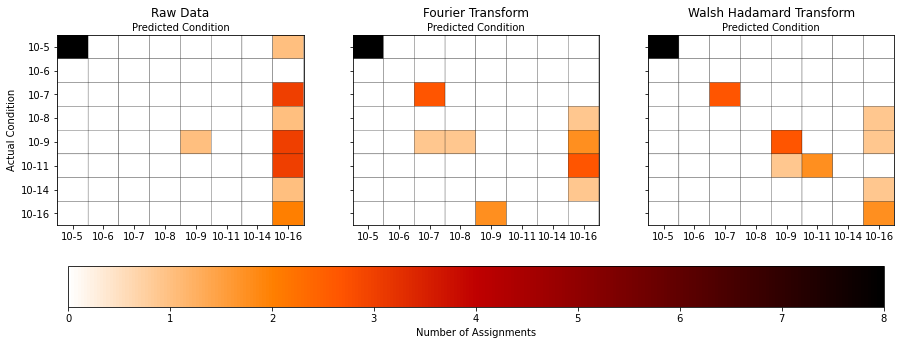

In [17]:
fig, axs = plt.subplots(1, 3, sharey = True, figsize = [15, 5])

plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True

pcm = axs[0].pcolor(CMSC, edgecolors = 'k', cmap = 'gist_heat_r')
plt.gca().invert_yaxis()
axs[0].set_xticks(ticks = np.linspace(0.5, len(labels)-0.5, num = len(labels)), labels = labels)
axs[0].set_yticks(ticks = np.linspace(0.5, len(labels)-0.5, num = len(labels)), labels = labels)
axs[0].set_ylabel("Actual Condition")
axs[0].set_xlabel("Predicted Condition")
axs[0].xaxis.set_label_position('top') 
axs[0].set_title('Raw Data');

axs[1].pcolor(CMFT, edgecolors = 'k', cmap = 'gist_heat_r');
plt.gca().invert_yaxis()
axs[1].set_xticks(ticks = np.linspace(0.5, len(labels)-0.5, num = len(labels)), labels = labels)
axs[1].set_title('Fourier Transform');
axs[1].set_xlabel("Predicted Condition")
axs[1].xaxis.set_label_position('top')

axs[2].pcolor(CMHT, edgecolors = 'k', cmap = 'gist_heat_r')
plt.gca().invert_yaxis()
axs[2].set_xticks(ticks = np.linspace(0.5, len(labels)-0.5, num = len(labels)), labels = labels);
axs[2].set_title('Walsh Hadamard Transform');
axs[2].set_xlabel("Predicted Condition")
axs[2].xaxis.set_label_position('top')

fig.colorbar(pcm, ax = axs[:], location = 'bottom', label = 'Number of Assignments');

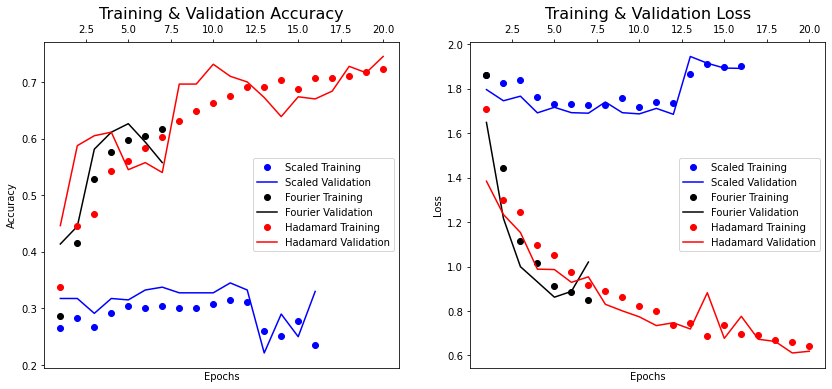

In [18]:
hist_dict = history_sc.history
train_loss = hist_dict['loss']
val_loss = hist_dict['val_loss']
train_acc = hist_dict['accuracy']
val_acc = hist_dict['val_accuracy']
epochs_vec = range(1, len(train_loss) + 1)


fig, ax = plt.subplots(1, 2, figsize=(14, 6))
#
# Plot the model accuracy vs Epochs
#
ax[0].plot(epochs_vec, train_acc, 'bo')
ax[0].plot(epochs_vec, val_acc, 'b')
#
# Plot the loss vs Epochs
#
ax[1].plot(epochs_vec, train_loss, 'bo')
ax[1].plot(epochs_vec, val_loss, 'b')

hist_dict = history_ft.history
train_loss = hist_dict['loss']
val_loss = hist_dict['val_loss']
train_acc = hist_dict['accuracy']
val_acc = hist_dict['val_accuracy']
epochs_vec = range(1, len(train_loss) + 1)

#
# Plot the model accuracy vs Epochs
#
ax[0].plot(epochs_vec, train_acc, 'ko')
ax[0].plot(epochs_vec, val_acc, 'k')

#
# Plot the loss vs Epochs
#
ax[1].plot(epochs_vec, train_loss, 'ko')
ax[1].plot(epochs_vec, val_loss, 'k')

hist_dict = history_ht.history
train_loss = hist_dict['loss']
val_loss = hist_dict['val_loss']
train_acc = hist_dict['accuracy']
val_acc = hist_dict['val_accuracy']
epochs_vec = range(1, len(train_loss) + 1)

#
# Plot the model accuracy vs Epochs
#
ax[0].plot(epochs_vec, train_acc, 'ro')
ax[0].plot(epochs_vec, val_acc, 'r')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Scaled Training', 'Scaled Validation', 'Fourier Training', 'Fourier Validation', 'Hadamard Training', 'Hadamard Validation'])
#
# Plot the loss vs Epochs
#
ax[1].plot(epochs_vec, train_loss, 'ro')
ax[1].plot(epochs_vec, val_loss, 'r')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Scaled Training', 'Scaled Validation', 'Fourier Training', 'Fourier Validation', 'Hadamard Training', 'Hadamard Validation']);

plt.savefig("Tables and Figures\SVG Files\CNN Learning Curve.svg", format = "svg", bbox_inches='tight')
plt.savefig("Tables and Figures\PNG Files\CNN Learning Curve.png", format = "png", bbox_inches='tight')